# Analyze DTI

Convert ANTs H5 warp files to fsl format
I used the c(3): 
https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=fsl;c21935f9.1901

 /Users/ranigera/Downloads/Convert3DGUI.app/Contents/bin/c3d_affine_tool -ref sub-175_desc-preproc_T1w.nii.gz -src sub-175_first_processed_B0_before.nii.gz sub-175_first_processed_B0_reg_to_native_T1_before.mat -fsl2ras -oitk ANTS_ref_T1.txt


antsApplyTransforms -i sub-175_first_processed_B0_before.nii.gz -r ${FSLDIR}/data/standard/MNI152_T1_2mm.nii.gz -o B0_in_mni_fromT1regFINAL.nii.gz -t sub-175_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5 -t ANTS_ref_T1.txt 



In [220]:
# import packages
# -----------------------------------------------------------------------------
# import pip
# pip.main(['install', 'seaborn']) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import subprocess
import sys
import json
import platform
import socket
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import stats


In [3]:
# parameters
# -----------------------------------------------------------------------------
MANUALLY_EXCLUDE_SUBJECTS = []

running_on = 'server' if 'Linux' in platform.system() else 'my_mac'

if running_on == 'my_mac':
    data_path = '/Users/ranigera/Dropbox/DTI_tests'
    preproc_path = '/Users/ranigera/Dropbox/DTI_tests/preproc'
    dti_path = '/Users/ranigera/Dropbox/DTI_tests/dti'
    stats_path = '/Users/ranigera/Dropbox/DTI_tests/stats_alt_reg'
    models_path = stats_path + '/models'
    launch_files_path = '/Users/ranigera/Dropbox/DTI_analysis/launch_files'
else:
    data_path = '/export2/DATA/HIS/HIS_server/BIDS'
    preproc_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/preproc'
    dti_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/dti'
    stats_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg'
    models_path = stats_path + '/models'
    launch_files_path = '/export2/DATA/HIS/HIS_server/codes_dwi/launch_files'
    behav_data_path = '/export2/DATA/HIS/HIS_server/analysis/behavior_analysis_output/my_databases/txt_data'

fmriPrepAnatomyDerivatives_path = data_path + '/derivatives/fmriprep'

expectedVolums = {
    'AP': 69,
    'PA' : 7,
    }
expectedB0s_indxs = {
    'AP_before': [0, 1, 18, 35, 52],
    'PA_before': [0, 2, 3, 4, 5, 6],
    'AP_after': [0, 1, 18, 35, 52],
    'PA_after': [0, 2, 3, 4, 5, 6]
    }

n_cores_TOPUP = 2

# setting EDDY stuff:
EDDY_command = 'eddy_openmp' if running_on == 'server' else 'eddy' # for the boost server
EDDY_command = 'eddy_cuda10.2' if running_on == 'server' else 'eddy' # for the cheshire server
ssh_command_for_cheshire_server = 'ssh shirangera@cheshire.tau.ac.il' if 'boost' in socket.gethostname() else ''

n_expected_EDDY_output_files = 13
n_cores_EDDY = 4 # relevant only for running using files (currently disabled as I run it on cheshire's GPU)

n_expected_DTIFIT_output_files = 10

masks_paths = {
    'Caudate': '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/CaudateHead_Y-larger-than-1-mask.nii.gz',
    'Putamen': '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/Putamen-mask.nii.gz',
    'vmPFC':   '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/vmPFC-mask.nii.gz',
}

In [4]:
# Define functions
# -----------------------------------------------------------------------------
def createSubjectScansBaseNames(subjFolder, data_path):
    sub = int(subjFolder.split("-",1)[1])
    group = '1day' if sub < 200 else '3day'
    last_sess = group[0]
    DWI_path_before = os.path.join(data_path, subjFolder, 'ses-1/dwi/')
    DWI_path_after = os.path.join(data_path, subjFolder, f'ses-{last_sess}/dwi/')
    scansBaseNames = {
        'AP_before': f'{os.path.join(DWI_path_before, "sub-" + str(sub) + "_ses-1_acq-ap_run-01_dwi")}',
        'PA_before' : f'{os.path.join(DWI_path_before, "sub-" + str(sub) + "_ses-1_acq-pa_run-01_dwi")}',
        'AP_after' : f'{os.path.join(DWI_path_after, "sub-" + str(sub) + "_ses-" + last_sess + "_acq-ap_run-02_dwi")}',
        'PA_after' : f'{os.path.join(DWI_path_after, "sub-" + str(sub) + "_ses-" + last_sess + "_acq-pa_run-02_dwi")}'
        }
    return scansBaseNames

def get_sub_B0_files(subjFolder, scansBaseNames, B0s_indxs):
    sub_B0s_files = []
    for scan in scansBaseNames.keys():
        for B0ind in B0s_indxs[scan]:
            B0_file_name = os.path.join(preproc_path, subjFolder, subjFolder + '_' + scan + "_b0_volInd-" + str(B0ind) + ".nii.gz")
            sub_B0s_files.append(B0_file_name)
    return sub_B0s_files


In [5]:
# Get folders and remove excluded subjects
# -----------------------------------------------------------------------------
print('>> Get sub folders')
subjFolders = [el for el in os.listdir(data_path) if 'sub' in el]

if running_on == 'my_mac':
    print('>> Get exclusion list')
    with open('/Users/ranigera/Google_Drive_TAU/Experiments/HIS_STUDY/Analysis/codes/paths_and_vars.py') as txtFile:
        txt = txtFile.read()
    participantsToExclude = [int(el) for el in txt.split('participantsToExclude = [')[1].split(']')[0].replace('\n','').replace('\n','').replace("'","").split(',')]

    print('>> Remove sub folders of excluded participants in case they are there')
    subjFolders = [el for el in subjFolders if int(el.split('-')[1]) not in participantsToExclude]

if MANUALLY_EXCLUDE_SUBJECTS:
    subjFolders = [el for el in subjFolders if int(el.split('-')[1]) not in MANUALLY_EXCLUDE_SUBJECTS]
    
subjFolders.sort()

>> Get sub folders


## Check for missing scans or wrong phase encoding directions for ALL SUBJECTS 

In [6]:
print ('>> Verify that all the scans exist and that the phase encoding directions are as they should.')
subjectsWithAProblem = []
for subjFolder in subjFolders:
    sub = int(subjFolder.split("-",1)[1])
    scansBaseNames = createSubjectScansBaseNames(subjFolder, data_path)
    for scan in scansBaseNames.keys():
        # print(scansBaseNames[scan] + '.json')
        # print(scanData['PhaseEncodingDirection'])
        if not os.path.exists(scansBaseNames[scan] + '.json'):
            subjectsWithAProblem.append(sub)
            print(' *** Scan not found: ' + scansBaseNames[scan] + '.json')
            continue
        with open(scansBaseNames[scan] + '.json') as json_file:        
            scanData = json.load(json_file)
            if ('acq-ap_' in scansBaseNames[scan] and scanData['PhaseEncodingDirection'] != 'j-') or \
                ('acq-pa_' in scansBaseNames[scan] and scanData['PhaseEncodingDirection'] != 'j'):
                subjectsWithAProblem.append(sub)
                print(' *** There is a problem with the scanning directions: ' + scansBaseNames[scan] + '.json is defined as ' + scanData['PhaseEncodingDirection'] + '.')
                continue

subjectsWithAProblem = list(set(subjectsWithAProblem))
subjectsWithAProblem.sort()

>> Verify that all the scans exist and that the phase encoding directions are as they should.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-110/ses-1/dwi/sub-110_ses-1_acq-pa_run-01_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-110/ses-1/dwi/sub-110_ses-1_acq-pa_run-02_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-204/ses-3/dwi/sub-204_ses-3_acq-pa_run-02_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-207/ses-1/dwi/sub-207_ses-1_acq-pa_run-01_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-209/ses-1/dwi/sub-209_ses-1_acq-pa_run-01_dwi.json is defined as j-.
 *** Scan not found: /export2/DATA/HIS/HIS_server/BIDS/sub-255/ses-1/dwi/sub-255_ses-1_acq-pa_run-01_

In [7]:
# Remove subjects with a problem
# -----------------------------------------------------------------------------
print('>> Remove subjects with a problem and sort the list')
subjFolders =[el for el in subjFolders if int(el.split('-')[1]) not in subjectsWithAProblem]
subjFolders.sort()

>> Remove subjects with a problem and sort the list


### Gather subject folders again based on the dti folders!
Make sure that before that you ran DWI_pipeline_noTOPUPpipeline.ipynb to include subject without TOPUP

In [8]:
print('>> Get sub folders from the DTI map folder')
subjFoldersDTI = [el for el in os.listdir(dti_path) if 'sub' in el]
subjFoldersDTI.sort()

>> Get sub folders from the DTI map folder


In [9]:
len(subjFoldersDTI)

121

# Statistical Analysis: BETWEEN-GRUOP

The analysis is based on this page: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#ANOVA:_2-groups.2C_2-levels_per_subject_.282-way_Mixed_Effect_ANOVA.29
Specifically:
"Randomise details
Due to how the data would need to be permuted, the FEAT model may not be used in randomise. Instead, just as in the paired t-test example, paired differences within-subject would be computed via fslmaths and a two-sample t-test could be used to test whether the run1-run2 difference differed between the two groups."

Thus the first step (calculating the differenceswithin-subject) is as here: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Paired_Difference_.28Paired_T-Test.29
And the second is as here 


In [141]:
print('> Calculate the difference of AFTER minus BEFORE and BEFORE minus AFTER for the MD and FA maps')
for subjFolder in subjFoldersDTI:
    if not os.path.exists(os.path.join(stats_path, 'MD', f'{subjFolder}_in-MNI_MD_AFTER-minus-BEFORE.nii.gz')) \
    or not os.path.exists(os.path.join(stats_path, 'FA', f'{subjFolder}_in-MNI_FA_AFTER-minus-BEFORE.nii.gz')) \
    or not os.path.exists(os.path.join(stats_path, 'MD', f'{subjFolder}_in-MNI_MD_BEFORE-minus-AFTER.nii.gz')) \
    or not os.path.exists(os.path.join(stats_path, 'FA', f'{subjFolder}_in-MNI_FA_BEFORE-minus-AFTER.nii.gz')):      
     
        for map_type in ['MD','FA']:          
            substraction_command = f"fslmaths {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_after.nii.gz')} -sub {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_before.nii.gz')} {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz')}"
            print(substraction_command)
            os.system(substraction_command)    
            substraction_command2 = f"fslmaths {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_before.nii.gz')} -sub {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_after.nii.gz')} {os.path.join(stats_path, map_type, f'{subjFolder}_in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz')}"
            print(substraction_command2)
            os.system(substraction_command2)    

> Calculate the difference of AFTER minus BEFORE and BEFORE minus AFTER for the MD and FA maps


In [27]:
print('> Create one file with all subjects of AFTER minus BEFORE and one withh all Before minus AFTER for the MD and FA maps')
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} `ls {os.path.join(stats_path, map_type, f'*in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz')}`")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} `ls {os.path.join(stats_path, map_type, f'*in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz')}`")
    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_BEFORE_minus_AFTER_{map_type}')} `ls {os.path.join(stats_path, map_type, f'*in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz')}`")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_BEFORE_minus_AFTER_{map_type}')} `ls {os.path.join(stats_path, map_type, f'*in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz')}`")

> Create one file with all subjects of AFTER minus BEFORE and one withh all Before minus AFTER for the MD and FA maps
fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD `ls /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/*in-MNI_MD_AFTER-minus-BEFORE.nii.gz`
fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_BEFORE_minus_AFTER_MD `ls /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/*in-MNI_MD_BEFORE-minus-AFTER.nii.gz`
fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/ALL_SUBJECTS_AFTER_minus_BEFORE_FA `ls /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/*in-MNI_FA_AFTER-minus-BEFORE.nii.gz`
fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/ALL_SUBJECTS_BEFORE_minus_AFTER_FA `ls /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/*in-MNI_FA_BEFORE-minus-AFTER.nii.gz`


In [142]:
print('> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)')
# create the folder
try:
    os.makedirs(os.path.join(models_path, 'between_groups'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'between_groups'))
except:
    pass

#create the design matrix and contrasts:
N_1_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])<200]))
N_3_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])>200]))

print(f"design_ttest2 {os.path.join(models_path, 'between_groups','design_unpaired_ttest')} {N_1_day_group} {N_3_day_group}")
os.system(f"design_ttest2 {os.path.join(models_path, 'between_groups','design_unpaired_ttest')} {N_1_day_group} {N_3_day_group}")

> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/between_groups/design_unpaired_ttest 61 60


0

### Settings

In [256]:
# a function to run randomise for the between-group analyses:
def runRandomiseGroupAnalysis(map_type, region):
    print(f'Running randomise for between-groups analysis:\n--- {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path, map_type, f'ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path, 'models', 'between_groups', f'design_unpaired_ttest.mat')} \
        -t {os.path.join(stats_path, 'models', 'between_groups', f'design_unpaired_ttest.con')}  \
        -n 6000 -C 3.1")


# Get cluster info:
def getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90'):
    print(f'Testing stats for between-group analysis:\n--- {map_type} | {region} ---\n')
    print(f'Test 1-Day > 3-Day\n')
    # * Increase in FA in the 1-day relatvie to the 3-days (or a decrease in the 3-day...)
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'3-Day > 1-Day\n')
    # * Increase in FA in the 3-day relatvie to the 1-days (or a decrease in the 1-day...)
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

# Create a binary mask for the clusters:
def createBinaryMaskGroupAnalysis(map_type, region, contrast, ReversedSigThresh='0.95'):
    print(f'Creating cluster binary mask for between-group analysis:\n--- contrast: {contrast} | {map_type} | {region} ---\n')
    print(f'fslmaths {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    # create also a t-stat of the significant cluster:
    print(f'fslmaths {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')


# gte mean value of the cluster using the binary mask:
def getMeanClusterValueGroupAnalysis(map_type, region, contrast):
    print(f'Getting mean values of the cluster for between-group analysis:\n--- contrast: {contrast} | {map_type} | {region} ---\n')
    print(f'fslstats -t {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M')
    avgs=os.popen(f'fslstats -t {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path, map_type, f"ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M').read()
    return [float(i) for i in avgs.split(' \n')[:-1]]

## Run the analyses analyses (through the terminal)

### NOTE:
* Contrast of group means are meaningeless, I think, with randomize (because to check this a paired t-test should be done exchanging before and after and it's not what is done here)

### Whole brain - FA

In [31]:
map_type='FA'
region='whole_brain'

In [32]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | whole_brain ---



In [33]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | whole_brain ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHIING

### Putamen - FA

In [34]:
region='Putamen'

In [35]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | Putamen ---



In [36]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | Putamen ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHIING

### Caudate - FA

In [37]:
region='Caudate'

In [38]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | Caudate ---



In [39]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | Caudate ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHIING

### vmPFC - FA

In [40]:
region='vmPFC'

In [41]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | vmPFC ---



In [42]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | vmPFC ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Whole brain - MD

In [43]:
map_type='MD'
region='whole_brain'

In [44]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | whole_brain ---



In [45]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | whole_brain ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Putamen - MD

In [46]:
region='Putamen'

In [47]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | Putamen ---



In [48]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | Putamen ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Caudate - MD

In [55]:
region='Caudate'

In [50]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | Caudate ---



In [59]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | Caudate ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:
There is a marginally signficant increase cluster in the Head of Caudate meaning more reduction in the 1-day group(!) or decrease in the 3-days. Maybe again there is something temporary!

I need to check what drives this


### vmPFC - MD

In [60]:
region='vmPFC'

In [53]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | vmPFC ---



In [61]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | vmPFC ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.99	41	79	31	41.5	79.3	31.5	4.67	42	80	31	3.72



>>>>> RESULTS:
There is a signficant increase cluster in the right vmPFC (mainly in the ACC) meaning more reduction in the 1-day group(!) or decrease in the 3-days. Maybe again there is something temporary!

I need to check what drives this: both increase here and decrease threre...


In [257]:
createBinaryMaskGroupAnalysis('MD', 'vmPFC', 2, ReversedSigThresh='0.95')
change_in_MD_long_vmPFC=getMeanClusterValueGroupAnalysis('MD', 'vmPFC', 2)

# create a dataframe from lists:
change_in_MD_vmPFC = pd.DataFrame([[int(sub.split('-')[-1]) for sub in subjFoldersDTI], ['Short' for i in range(N_1_day_group)] + ['Extensive' for i in range(N_3_day_group)], change_in_MD_long_vmPFC]).T
change_in_MD_vmPFC.columns = ['subID', 'group', 'change_in_MD_vmPFC']


Creating cluster binary mask for between-group analysis:
--- contrast: 2 | MD | vmPFC ---

fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD_vmPFC_clusterm_corrp_tstat2.nii.gz         -thr 0.95 -bin /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD_vmPFC_contrast_2_bin_mask.nii.gz
fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD_vmPFC_tstat2.nii.gz         -mul /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD_vmPFC_contrast_2_bin_mask.nii.gz             /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_minus_BEFORE_MD_vmPFC_tstat2_in_sig_cluster.nii.gz
Getting mean values of the cluster for between-group analysis:
--- contrast: 2 | MD | vmPFC ---

fslstats -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/ALL_SUBJECTS_AFTER_

In [170]:
change_in_MD_vmPFC

,subID,group,change_in_MD_vmPFC
0,103,Short,-1.3e-05
1,104,Short,-2.5e-05
2,106,Short,-1.1e-05
3,107,Short,-1.4e-05
4,108,Short,1.9e-05
...,...,...,...
116,281,Extensive,5.5e-05
117,282,Extensive,5.4e-05
118,283,Extensive,-2.8e-05
119,284,Extensive,6e-06


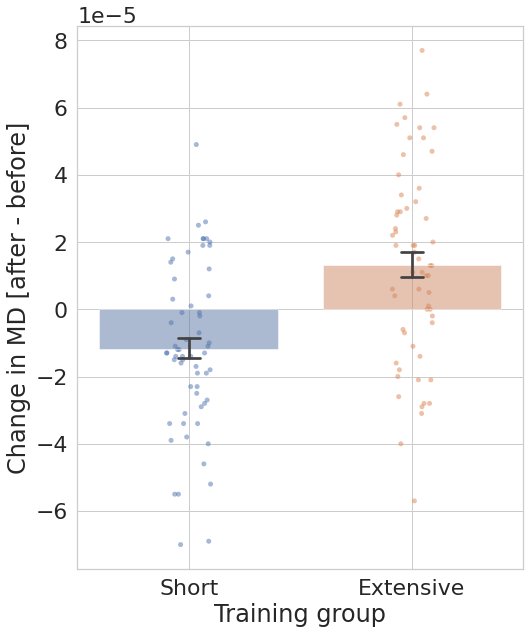

In [259]:
sns.set(font_scale = 2)
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1,figsize=(8,10))
sns.stripplot(x="group", y="change_in_MD_vmPFC", data=change_in_MD_vmPFC, ax=axs, zorder=2, alpha= 0.5)
sns.barplot(x="group", y="change_in_MD_vmPFC", data=change_in_MD_vmPFC, ci=68, ax=axs,alpha=0.5, zorder=2, capsize=0.1)
axs.set(xlabel='Training group', ylabel='Change in MD [after - before]')
axs.xaxis.grid()



In [219]:
# two group t-test:
t, p = stats.ttest_ind(change_in_MD_vmPFC[change_in_MD_vmPFC.group=='Short'].change_in_MD_vmPFC, change_in_MD_vmPFC[change_in_MD_vmPFC.group=='Extensive'].change_in_MD_vmPFC, equal_var=False)
print(t,p)

-5.075650299336278 1.4946169080794097e-06


# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Statistics - individual differences

### Create the habit index csv file (by running a dedicated matlab folder)


In [62]:
# Create the habit index csv file (by running a dedicated matlab folder)
!matlab -nodesktop -nosplash -r "run('/export2/DATA/HIS/HIS_server/codes/create_HABIT_INDEX_table')";

MATLAB is selecting SOFTWARE OPENGL rendering.
=
                            < M A T L A B (R) >
                  Copyright 1984-2020 The MathWorks, Inc.
                  R2020a (9.8.0.1323502) 64-bit (glnxa64)
                             February 25, 2020

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
** CREATED new habit index file **
>

### Prepare and arrange the behavioral data and DTI folder data for all together and for each group seperately

In [95]:
# First, create subjects list folder for each group:
subjFoldersDTI_short = [sub for sub in subjFoldersDTI if int(sub.split('-')[-1])<200]
subjFoldersDTI_long = [sub for sub in subjFoldersDTI if int(sub.split('-')[-1])>200]

# Get the behavioral data:
behav_all = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_ALL.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_all.subID if 'sub-' + str(sub) not in subjFoldersDTI]
behav_all = behav_all[~behav_all.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_all.subID] == subjFoldersDTI:
    raise Exception('Subject lists are not matching')

# Repeat for the long training groups:
behav_long = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_LONG.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_long.subID if 'sub-' + str(sub) not in subjFoldersDTI_long]
behav_long = behav_long[~behav_long.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_long.subID] == subjFoldersDTI_long:
    raise Exception('Subject lists are not matching')
    
# Repeat for the short training groups:
behav_short = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_SHORT.csv'))
behav_short = behav_short[behav_short.subID != 159] # ******************************* testing something without this subject
subjFoldersDTI_short = [sub for sub in subjFoldersDTI_short if sub != 'sub-159'] # ******************************* testing something without this subject
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_short.subID if 'sub-' + str(sub) not in subjFoldersDTI_short]
behav_short = behav_short[~behav_short.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_short.subID] == subjFoldersDTI_short:
    raise Exception('Subject lists are not matching')



In [96]:
len(behav_short)

60

### prepare the design matrix

In [97]:
print('> Create the individual differences design matrix')
# define file names:
design_indiv_diff_LONG = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff_LONG.mat')
design_indiv_diff_SHORT = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff_SHORT.mat')
contrasts_indiv_diff = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff.con')

# create the folder
try:
    os.makedirs(os.path.join(models_path, 'individual_differences'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'individual_differences'))
except:
    pass

# write the design matrix files:
behav_long.habit_index_mean_centered.to_csv(f"{design_indiv_diff_LONG.split('.')[0]}_temp.mat", index=False, header=False)
behav_short.habit_index_mean_centered.to_csv(f"{design_indiv_diff_SHORT.split('.')[0]}_temp.mat", index=False, header=False)

# write the contrast file:
with open(f"{contrasts_indiv_diff.split('.')[0]}_temp.mat", 'w') as f:
    f.write('1\n-1\n')

# use the fsl command Text2Vect to make the design files good for randomise:
print(f"Text2Vest {design_indiv_diff_LONG.split('.')[0]}_temp.mat {design_indiv_diff_LONG}")
os.system(f"Text2Vest {design_indiv_diff_LONG.split('.')[0]}_temp.mat {design_indiv_diff_LONG}")
print(f"Text2Vest {design_indiv_diff_SHORT.split('.')[0]}_temp.mat {design_indiv_diff_SHORT}")
os.system(f"Text2Vest {design_indiv_diff_SHORT.split('.')[0]}_temp.mat {design_indiv_diff_SHORT}")
print(f"Text2Vest {contrasts_indiv_diff.split('.')[0]}_temp.mat {contrasts_indiv_diff}")
os.system(f"Text2Vest {contrasts_indiv_diff.split('.')[0]}_temp.mat {contrasts_indiv_diff}")

# finally, remove the temporary files:
os.remove(f"{design_indiv_diff_LONG.split('.')[0]}_temp.mat")
os.remove(f"{design_indiv_diff_SHORT.split('.')[0]}_temp.mat")
os.remove(f"{contrasts_indiv_diff.split('.')[0]}_temp.mat")

> Create the individual differences design matrix
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff_LONG_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff_LONG.mat
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff_SHORT_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff_SHORT.mat
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/individual_differences/design_indivdual_diff.con


### Create one file with each group's participants together

In [98]:
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'LONG_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_long])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'LONG_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_long])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SHORT_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_short])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SHORT_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_short])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'LONG_individualDiff_BEFORE_minus_AFTER_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz') for sub in subjFoldersDTI_long])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'LONG_individualDiff_BEFORE_minus_AFTER_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz') for sub in subjFoldersDTI_long])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SHORT_individualDiff_BEFORE_minus_AFTER_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz') for sub in subjFoldersDTI_short])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SHORT_individualDiff_BEFORE_minus_AFTER_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_BEFORE-minus-AFTER.nii.gz') for sub in subjFoldersDTI_short])}")


fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/LONG_individualDiff_AFTER_minus_BEFORE_MD /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-204_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-205_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-207_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-208_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-209_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-210_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-212_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-214_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/

### Settings

In [260]:
# a function to run randomise for the individual differences analyses:
def runRandomiseIndividualDiffs(group, map_type, region):
    print(f'Running randomise for individual differences:\n--- {group} training group | {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path, map_type, f'{group}_individualDiff_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path, map_type, f'{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path, 'models', 'individual_differences', f'design_indivdual_diff_{group}.mat')} \
        -t {os.path.join(stats_path, 'models', 'individual_differences', 'design_indivdual_diff.con')}  \
        -n 6000 -C 3.1 -D")


# Get cluster info:
def getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90'):
    print(f'Test for POSITIVE relationship between:\n--- increase in {map_type} and GOAL-DIRECTEDNESS in: {region} | group: {group} ---\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'Test for NEGATIVE relationship between:\n--- increase in {map_type} and GOAL-DIRECTEDNESS in: {region} | group: {group} ---\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

# Create a binary mask for the clusters:
def createBinaryMaskIndividualDiffs(group, map_type, region, contrast, ReversedSigThresh='0.95'):
    print(f'Create a binary mask for the cluster:\n--- contrast {contrast} in: {map_type} | {region} | group: {group} ---\n')
    print(f'fslmaths {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    # create also a t-stat of the significant cluster:
    print(f'fslmaths {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')


# get mean value of the cluster using a mask:
def getClusterMeans(group, map_type, region, contrast):
    print(f'Get mean value of a cluster:\n--- contrast {contrast} in: {map_type} | {region} | group: {group} ---\n')
    print(f'fslstats -t {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M')    
    avgs=os.popen(f'fslstats -t {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path, map_type, f"{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M').read()
    return [float(i) for i in avgs.split(' \n')[:-1]]
    

## SHORT TRAINING

In [100]:
group = 'SHORT'

### Whole brain - FA

In [68]:
map_type='FA'
region='whole_brain'

In [69]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | whole_brain ---



In [70]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Putamen - FA

In [71]:
region='Putamen'

In [72]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | Putamen ---



In [73]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Caudate - FA

In [74]:
region='Caudate'

In [75]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | Caudate ---



In [76]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### vmPFC - FA

In [77]:
region='vmPFC'

In [78]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | vmPFC ---



In [79]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Whole brain - MD

In [101]:
map_type='MD'
region='whole_brain'

In [81]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | whole_brain ---



In [82]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Putamen - MD

In [83]:
region='Putamen'

In [84]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | Putamen ---



In [85]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Caudate - MD

In [86]:
region='Caudate'

In [87]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | Caudate ---



In [88]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### vmPFC - MD

In [102]:
region='vmPFC'

In [103]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | vmPFC ---



In [91]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	8	0.963	51	71	23	51.2	71.3	24	3.97	52	72	23	3.62

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	5	0.917	51	73	24	50.4	73.2	25	4.16	50	73	25	3.76



>>>>> RESULTS: Marginally significane in the vmPFC - a negative relationship between goal-directedness and change (increase) in MD  => reduction in MD more goal-directedness.

Test without 159 (who is a crazy outlier...)

In [106]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.50')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
2	3	0.73	50	97	25	51	97	25	3.83	51	97	25	3.47
1	2	0.632	46	93	30	46.5	93	30	4.79	47	93	30	4.16

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.7	42	92	22	41	92.3	22.7	3.51	41	93	23	3.32



In [261]:
createBinaryMaskIndividualDiffs('SHORT', 'MD', 'vmPFC', 1, ReversedSigThresh='0.95')
change_in_MD_short_vmPFC=getClusterMeans('SHORT', 'MD', 'vmPFC', 1)
behav_short['change_in_MD']=change_in_MD_short_vmPFC
    

Create a binary mask for the cluster:
--- contrast 1 in: MD | vmPFC | group: SHORT ---

fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_clusterm_corrp_tstat1.nii.gz         -thr 0.95 -bin /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_contrast_1_bin_mask.nii.gz
fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_tstat1.nii.gz         -mul /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_contrast_1_bin_mask.nii.gz             /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_tstat1_in_sig_cluster.nii.gz
Get mean value of a cluster:
--- contrast 1 in: MD | vmPFC | group: SHORT ---

fslstats -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/

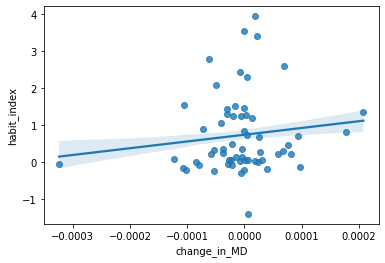

In [69]:
std_for_outliers = 2
behav_short_no_outiers = behav_short[(behav_short['change_in_MD'] > (np.mean(behav_short['change_in_MD']) - std_for_outliers*np.std(behav_short['change_in_MD']))) & (behav_short['change_in_MD'] < (np.mean(behav_short['change_in_MD']) + std_for_outliers*np.std(behav_short['change_in_MD'])))]
sns.regplot(x="change_in_MD", y="habit_index", data=behav_short_no_outiers, ci=68);


## LONG TRAINING

In [92]:
group = 'LONG'

### Whole brain - FA

In [93]:
map_type='FA'
region='whole_brain'

In [94]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | whole_brain ---



In [95]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Putamen - FA

In [96]:
region='Putamen'

In [97]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | Putamen ---



In [98]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Caudate - FA

In [99]:
region='Caudate'

In [100]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | Caudate ---



In [101]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### vmPFC - FA

In [102]:
region='vmPFC'

In [103]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | vmPFC ---



In [104]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	4	0.929	50	94	31	50.2	94.8	31.7	4.31	51	95	33	3.6

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

In [262]:
createBinaryMaskIndividualDiffs('LONG', 'FA', 'vmPFC', 1, ReversedSigThresh='0.90')
change_in_FA_long_vmPFC=getClusterMeans('LONG', 'FA', 'vmPFC', 1)
behav_long['change_in_FA_vmPFC']=change_in_FA_long_vmPFC


Create a binary mask for the cluster:
--- contrast 1 in: FA | vmPFC | group: LONG ---

fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_individualDiff_AFTER_minus_BEFORE_FA_vmPFC_clusterm_corrp_tstat1.nii.gz         -thr 0.90 -bin /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_individualDiff_AFTER_minus_BEFORE_FA_vmPFC_contrast_1_bin_mask.nii.gz
fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_individualDiff_AFTER_minus_BEFORE_FA_vmPFC_tstat1.nii.gz         -mul /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_individualDiff_AFTER_minus_BEFORE_FA_vmPFC_contrast_1_bin_mask.nii.gz             /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_individualDiff_AFTER_minus_BEFORE_FA_vmPFC_tstat1_in_sig_cluster.nii.gz
Get mean value of a cluster:
--- contrast 1 in: FA | vmPFC | group: LONG ---

fslstats -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/FA/LONG_in

[Text(0, 0.5, 'Habit index'), Text(0.5, 0, 'Change in FA [after - before]')]

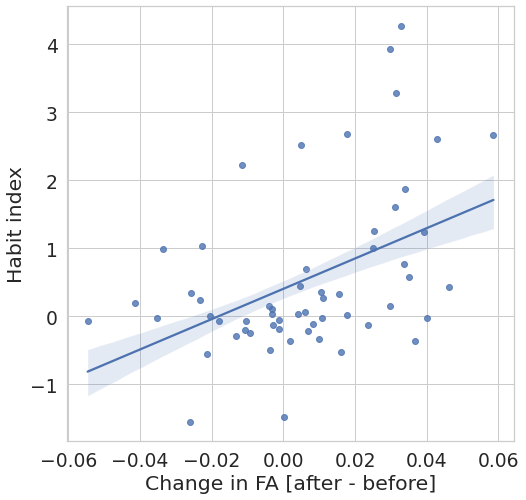

In [268]:
std_for_outliers = 2
behav_long_no_outiers = behav_long[(behav_long['change_in_FA_vmPFC'] > (np.mean(behav_long['change_in_FA_vmPFC']) - std_for_outliers*np.std(behav_long['change_in_FA_vmPFC']))) & (behav_long['change_in_FA_vmPFC'] < (np.mean(behav_long['change_in_FA_vmPFC']) + std_for_outliers*np.std(behav_long['change_in_FA_vmPFC'])))]

sns.set(font_scale = 1.7)
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1,figsize=(8,8))
sns.regplot(x="change_in_FA_vmPFC", y="habit_index", data=behav_long_no_outiers, ci=68, ax=axs);
axs.set(ylabel='Habit index', xlabel='Change in FA [after - before]')


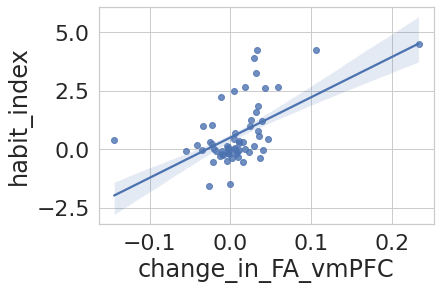

In [132]:
behav_long.corr(method='spearman')
print(pearsonr(behav_long['change_in_FA_vmPFC'], behav_long['habit_index']))
print(spearmanr(behav_long['change_in_FA_vmPFC'], behav_long['habit_index']))

(0.5620739522859473, 2.9650468095093995e-06)


SpearmanrResult(correlation=0.4550152820227842, pvalue=0.0002595745820088178)

### Whole brain - MD

In [105]:
map_type='MD'
region='whole_brain'

In [106]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | whole_brain ---



In [107]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Putamen - MD

In [108]:
region='Putamen'

In [109]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | Putamen ---



In [110]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Caudate - MD

In [111]:
region='Caudate'

In [112]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | Caudate ---



In [113]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### vmPFC - MD

In [114]:
region='vmPFC'

In [115]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | vmPFC ---



In [116]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Statistics - Exploratory SUBGROUPS analysis (subgroups of habitual and goal-directed participants are inferred based on the behavioral measure)

### Prepare and arrange the behavioral data and the corresponding DTI folders data variables

In [117]:
# Get the behavioral data:
behav_clustered_all = pd.read_csv(os.path.join(behav_data_path, 'clustered_subgroups_HIS_May_2022.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data2 = [sub for sub in behav_clustered_all.ID if 'sub-' + str(sub) not in subjFoldersDTI]
behav_clustered_all = behav_clustered_all[~behav_clustered_all.ID.isin(absent_from_DTI_data2)]

# remove subjects that were excluded from the behavioral sub-groups clusters:
absent_from_behav_clusters = [sub for sub in subjFoldersDTI if int(sub.split('-')[1]) not in list(behav_clustered_all.ID)]
subjFoldersDTI_forSubgroups = [sub for sub in subjFoldersDTI if sub not in absent_from_behav_clusters]

# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_clustered_all.ID] == subjFoldersDTI_forSubgroups:
    raise Exception('Subject lists are not matching')
    #pass # for debugging

# create variables foreach group seperately and for the subgroups seperately:
behav_clustered_short = behav_clustered_all[behav_clustered_all.ID < 200]
behav_clustered_long = behav_clustered_all[behav_clustered_all.ID > 200]
behav_clustered_goal_directed = behav_clustered_all[behav_clustered_all.Cluster == 'Goal-directed']
behav_clustered_habitual = behav_clustered_all[behav_clustered_all.Cluster == 'Habitual']

# sort the data according to the subgroups and create matching lists for the DTI data:
behav_clustered_short = behav_clustered_short.sort_values(by=['Cluster', 'ID']).reset_index(drop=True)
subjFoldersDTI_clustered_short = ['sub-' + str(sub) for sub in behav_clustered_short.ID]

behav_clustered_long = behav_clustered_long.sort_values(by=['Cluster', 'ID']).reset_index(drop=True)
subjFoldersDTI_clustered_long = ['sub-' + str(sub) for sub in behav_clustered_long.ID]

behav_clustered_goal_directed = behav_clustered_goal_directed.sort_values(by=['ID']).reset_index(drop=True)
subjFoldersDTI_clustered_goal_directed = ['sub-' + str(sub) for sub in behav_clustered_goal_directed.ID]

behav_clustered_habitual = behav_clustered_habitual.sort_values(by=['ID']).reset_index(drop=True)
subjFoldersDTI_clustered_habitual = ['sub-' + str(sub) for sub in behav_clustered_habitual.ID]

In [118]:
subjFoldersDTI_clustered_short #goal-directed then habitual - from behav_clustered_short
subjFoldersDTI_clustered_long #goal-directed then habitual - from behav_clustered_long
subjFoldersDTI_clustered_goal_directed #1-day then 3-day - from behav_clustered_goal_directed
subjFoldersDTI_clustered_habitual #1-day then 3-day - from behav_clustered_habitual


['sub-104',
 'sub-106',
 'sub-108',
 'sub-110',
 'sub-113',
 'sub-114',
 'sub-115',
 'sub-117',
 'sub-118',
 'sub-121',
 'sub-122',
 'sub-126',
 'sub-129',
 'sub-130',
 'sub-138',
 'sub-141',
 'sub-142',
 'sub-143',
 'sub-146',
 'sub-147',
 'sub-148',
 'sub-149',
 'sub-150',
 'sub-152',
 'sub-153',
 'sub-155',
 'sub-156',
 'sub-160',
 'sub-162',
 'sub-164',
 'sub-166',
 'sub-167',
 'sub-172',
 'sub-204',
 'sub-205',
 'sub-207',
 'sub-209',
 'sub-210',
 'sub-212',
 'sub-215',
 'sub-218',
 'sub-229',
 'sub-230',
 'sub-232',
 'sub-239',
 'sub-240',
 'sub-243',
 'sub-245',
 'sub-247',
 'sub-249',
 'sub-251',
 'sub-252',
 'sub-254',
 'sub-257',
 'sub-258',
 'sub-260',
 'sub-261',
 'sub-262',
 'sub-263',
 'sub-264',
 'sub-265',
 'sub-270',
 'sub-271',
 'sub-272',
 'sub-281',
 'sub-282',
 'sub-283',
 'sub-285']

### prepare the design matrix

In [119]:
print('> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)')
# create the folder
try:
    os.makedirs(os.path.join(models_path, 'sub_groups'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'sub_groups'))
except:
    pass

# create the design matrix and contrasts:
N_goal_directed_in_clustered_1_DAY = behav_clustered_short.Cluster.value_counts()['Goal-directed']
N_habitual_in_clustered_1_DAY = behav_clustered_short.Cluster.value_counts()['Habitual']
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_1_Day')} {N_goal_directed_in_clustered_1_DAY} {N_habitual_in_clustered_1_DAY}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_1_Day')} {N_goal_directed_in_clustered_1_DAY} {N_habitual_in_clustered_1_DAY}")

N_goal_directed_in_clustered_3_DAY = behav_clustered_long.Cluster.value_counts()['Goal-directed']
N_habitual_in_clustered_3_DAY = behav_clustered_long.Cluster.value_counts()['Habitual']
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_3_Day')} {N_goal_directed_in_clustered_3_DAY} {N_habitual_in_clustered_3_DAY}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_3_Day')} {N_goal_directed_in_clustered_3_DAY} {N_habitual_in_clustered_3_DAY}")

N_1_DAY_in_clustered_goal_directed = len(set([sub for sub in subjFoldersDTI_clustered_goal_directed if int(sub.split('-')[-1])<200]))
N_3_DAY_in_clustered_goal_directed = len(set([sub for sub in subjFoldersDTI_clustered_goal_directed if int(sub.split('-')[-1])>200]))
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Goal_Directed')} {N_1_DAY_in_clustered_goal_directed} {N_3_DAY_in_clustered_goal_directed}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Goal_Directed')} {N_1_DAY_in_clustered_goal_directed} {N_3_DAY_in_clustered_goal_directed}")

N_1_DAY_in_clustered_habitual = len(set([sub for sub in subjFoldersDTI_clustered_habitual if int(sub.split('-')[-1])<200]))
N_3_DAY_in_clustered_habitual = len(set([sub for sub in subjFoldersDTI_clustered_habitual if int(sub.split('-')[-1])>200]))
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Habitual')} {N_1_DAY_in_clustered_habitual} {N_3_DAY_in_clustered_habitual}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Habitual')} {N_1_DAY_in_clustered_habitual} {N_3_DAY_in_clustered_habitual}")


> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)
>> Created folder: /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/sub_groups
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/sub_groups/design_unpaired_ttest_subgroups_in_1_Day 27 33
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/sub_groups/design_unpaired_ttest_subgroups_in_3_Day 20 35
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/sub_groups/design_unpaired_ttest_subgroups_in_Goal_Directed 27 20
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/models/sub_groups/design_unpaired_ttest_subgroups_in_Habitual 33 35


0

### Create one file with each group's participants together

In [120]:
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_short])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_short])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_3_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_long])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_3_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_long])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_Goal_Directed_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_goal_directed])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_Goal_Directed_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_goal_directed])}")

    print(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_Habitual_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_habitual])}")
    os.system(f"fslmerge -t {os.path.join(stats_path, map_type, f'SUBGROUPS_in_Habitual_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_habitual])}")
    

fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_MD /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-103_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-107_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-119_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-120_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-124_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-127_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-128_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-131_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/H

### Settings

In [122]:
# a function to run randomise for the individual differences analyses:
def runRandomiseSubgroups(subgroups_in, map_type, region):
    print(f'Running randomise for sub-groups analysis:\n--- Subgroups in {subgroups_in} | {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path, map_type, f'SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path, map_type, f'SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.mat')} \
        -t {os.path.join(stats_path, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.con')}  \
        -n 6000 -C 3.1")

# Get cluster info:
def getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90'):
    print(f'Testing stats for sub-groups analysis:\n--- Subgroups in {subgroups_in} | {map_type} | {region} ---\n')
    print(f'Goal-directed > Test Habitual \n' if subgroups_in in ['1_Day','3_Day'] else f'1-Day > 3-Day\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'Test Habitual > Goal-Directed \n' if subgroups_in in ['1_Day','3_Day'] else f'3-Day > 1-Day\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path, map_type, f"SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path, map_type, f"SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())


## IN SHORT TRAINING

In [123]:
subgroups_in = '1_Day'

### Whole brain - FA

In [124]:
map_type='FA'
region='whole_brain'

In [125]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---



In [126]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Putamen - FA

In [127]:
region='Putamen'

In [128]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---



In [129]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.935	34	58	38	33.3	58	39	4.19	33	58	40	3.63

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Caudate - FA

In [130]:
region='Caudate'

In [131]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Caudate ---



In [132]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:
MMM... need to look into it

### vmPFC - FA

In [133]:
region='vmPFC'

In [134]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | vmPFC ---



In [135]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Whole brain - MD

In [136]:
map_type='MD'
region='whole_brain'

In [137]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | whole_brain ---



In [138]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Putamen - MD

In [139]:
region='Putamen'

In [140]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Putamen ---



In [141]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Caudate - MD

In [142]:
region='Caudate'

In [143]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Caudate ---



In [144]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### vmPFC - MD

In [145]:
region='vmPFC'

In [146]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | vmPFC ---



In [147]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	4	0.96	38	86	25	38.5	85.5	25.8	4.09	38	85	26	3.65

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

## IN LONG TRAINING

In [148]:
subgroups_in = '3_Day'

### Whole brain - FA

In [149]:
map_type='FA'
region='whole_brain'

In [150]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | whole_brain ---



In [151]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - FA

In [152]:
region='Putamen'

In [153]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Putamen ---



In [154]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.986	36	71	33	36.5	70.7	33.8	3.97	36	72	33	3.57



>>>>> RESULT

### Caudate - FA

In [155]:
region='Caudate'

In [156]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Caudate ---



In [157]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.993	36	71	33	36.5	70.7	33.8	3.97	36	72	33	3.57



>>>>> RESULTS:

### vmPFC - FA

In [158]:
region='vmPFC'

In [159]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | vmPFC ---



In [160]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### Whole brain - MD

In [161]:
map_type='MD'
region='whole_brain'

In [162]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | whole_brain ---



In [163]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - MD

In [164]:
region='Putamen'

In [165]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | Putamen ---



In [166]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - MD

In [167]:
region='Caudate'

In [168]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | Caudate ---



In [169]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### vmPFC - MD

In [170]:
region='vmPFC'

In [171]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | vmPFC ---



In [172]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

## IN HABITUAL

In [173]:
subgroups_in = 'Habitual'

### Whole brain - FA

In [174]:
map_type='FA'
region='whole_brain'

In [175]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | FA | whole_brain ---



In [176]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | FA | whole_brain ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - FA

In [177]:
region='Putamen'

In [178]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | FA | Putamen ---



In [179]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | FA | Putamen ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - FA

In [180]:
region='Caudate'

In [181]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | FA | Caudate ---



In [182]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | FA | Caudate ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### vmPFC - FA

In [183]:
region='vmPFC'

In [184]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | FA | vmPFC ---



In [185]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | FA | vmPFC ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
2	3	0.919	41	81	27	41	82	27	3.42	41	81	27	3.37
1	3	0.919	49	99	31	50	99	31	3.5	51	99	31	3.36

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### Whole brain - MD

In [186]:
map_type='MD'
region='whole_brain'

In [187]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | MD | whole_brain ---



In [188]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | MD | whole_brain ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - MD

In [189]:
region='Putamen'

In [190]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | MD | Putamen ---



In [191]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | MD | Putamen ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - MD

In [192]:
region='Caudate'

In [193]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | MD | Caudate ---



In [194]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | MD | Caudate ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.983	41	71	41	40.2	70.8	42	3.95	40	69	43	3.5



>>>>> RESULTS:

### vmPFC - MD

In [195]:
region='vmPFC'

In [196]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Habitual | MD | vmPFC ---



In [197]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Habitual | MD | vmPFC ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

## IN GOAL-DIRECTED

In [198]:
subgroups_in = 'Goal_Directed'

### Whole brain - FA

In [199]:
map_type='FA'
region='whole_brain'

In [200]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | whole_brain ---



In [201]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | whole_brain ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - FA

In [202]:
region='Putamen'

In [203]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | Putamen ---



In [204]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | Putamen ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - FA

In [205]:
region='Caudate'

In [206]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | Caudate ---



In [207]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | Caudate ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### vmPFC - FA

In [208]:
region='vmPFC'

In [209]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | vmPFC ---



In [210]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | FA | vmPFC ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### Whole brain - MD

In [211]:
map_type='MD'
region='whole_brain'

In [212]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | whole_brain ---



In [213]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | whole_brain ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - MD

In [214]:
region='Putamen'

In [215]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | Putamen ---



In [216]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | Putamen ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	5	0.958	38	69	34	37.2	70.8	34.4	3.6	38	69	34	3.31



>>>>> RESULT

### Caudate - MD

In [217]:
region='Caudate'

In [218]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | Caudate ---



In [219]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | Caudate ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	7	0.982	38	69	34	37.4	71.3	34.4	3.6	38	69	34	3.31



>>>>> RESULTS:

### vmPFC - MD

In [220]:
region='vmPFC'

In [221]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | vmPFC ---



In [222]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in Goal_Directed | MD | vmPFC ---

1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: